In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 10,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_10_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 14:19 - loss: 0.0155 - STD: 1.9059e-04 - MAE: 0.1082

 11/793 [..............................] - ETA: 4s - loss: 0.0126 - STD: 5.3794e-04 - MAE: 0.0883   

 20/793 [..............................] - ETA: 4s - loss: 0.0115 - STD: 8.2159e-04 - MAE: 0.0831

 29/793 [>.............................] - ETA: 4s - loss: 0.0109 - STD: 0.0011 - MAE: 0.0810    

 38/793 [>.............................] - ETA: 4s - loss: 0.0105 - STD: 0.0016 - MAE: 0.0798

 46/793 [>.............................] - ETA: 4s - loss: 0.0102 - STD: 0.0023 - MAE: 0.0789

 55/793 [=>............................] - ETA: 4s - loss: 0.0099 - STD: 0.0036 - MAE: 0.0778

 64/793 [=>............................] - ETA: 4s - loss: 0.0096 - STD: 0.0062 - MAE: 0.0768

 73/793 [=>............................] - ETA: 4s - loss: 0.0094 - STD: 0.0101 - MAE: 0.0758

 82/793 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 0.0138 - MAE: 0.0750

 91/793 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0166 - MAE: 0.0742

 99/793 [==>...........................] - ETA: 4s - loss: 0.0088 - STD: 0.0188 - MAE: 0.0734

108/793 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0211 - MAE: 0.0727

117/793 [===>..........................] - ETA: 4s - loss: 0.0085 - STD: 0.0232 - MAE: 0.0720

126/793 [===>..........................] - ETA: 4s - loss: 0.0084 - STD: 0.0249 - MAE: 0.0713

135/793 [====>.........................] - ETA: 3s - loss: 0.0082 - STD: 0.0266 - MAE: 0.0706

144/793 [====>.........................] - ETA: 3s - loss: 0.0081 - STD: 0.0281 - MAE: 0.0699

152/793 [====>.........................] - ETA: 3s - loss: 0.0080 - STD: 0.0294 - MAE: 0.0693

161/793 [=====>........................] - ETA: 3s - loss: 0.0078 - STD: 0.0310 - MAE: 0.0686

162/793 [=====>........................] - ETA: 5s - loss: 0.0078 - STD: 0.0311 - MAE: 0.0685

173/793 [=====>........................] - ETA: 5s - loss: 0.0077 - STD: 0.0328 - MAE: 0.0678

181/793 [=====>........................] - ETA: 5s - loss: 0.0076 - STD: 0.0339 - MAE: 0.0673

190/793 [======>.......................] - ETA: 5s - loss: 0.0075 - STD: 0.0351 - MAE: 0.0669

199/793 [======>.......................] - ETA: 5s - loss: 0.0074 - STD: 0.0361 - MAE: 0.0664

208/793 [======>.......................] - ETA: 4s - loss: 0.0073 - STD: 0.0370 - MAE: 0.0659

216/793 [=======>......................] - ETA: 4s - loss: 0.0072 - STD: 0.0378 - MAE: 0.0655

225/793 [=======>......................] - ETA: 4s - loss: 0.0072 - STD: 0.0388 - MAE: 0.0651

234/793 [=======>......................] - ETA: 4s - loss: 0.0071 - STD: 0.0396 - MAE: 0.0647

243/793 [========>.....................] - ETA: 4s - loss: 0.0070 - STD: 0.0404 - MAE: 0.0644

252/793 [========>.....................] - ETA: 4s - loss: 0.0070 - STD: 0.0411 - MAE: 0.0640

260/793 [========>.....................] - ETA: 4s - loss: 0.0069 - STD: 0.0418 - MAE: 0.0637

268/793 [=========>....................] - ETA: 4s - loss: 0.0069 - STD: 0.0424 - MAE: 0.0635

277/793 [=========>....................] - ETA: 4s - loss: 0.0068 - STD: 0.0429 - MAE: 0.0632

285/793 [=========>....................] - ETA: 3s - loss: 0.0068 - STD: 0.0434 - MAE: 0.0629

294/793 [==========>...................] - ETA: 3s - loss: 0.0067 - STD: 0.0440 - MAE: 0.0627

303/793 [==========>...................] - ETA: 3s - loss: 0.0067 - STD: 0.0444 - MAE: 0.0624

311/793 [==========>...................] - ETA: 3s - loss: 0.0066 - STD: 0.0449 - MAE: 0.0622

319/793 [===========>..................] - ETA: 3s - loss: 0.0066 - STD: 0.0454 - MAE: 0.0619

327/793 [===========>..................] - ETA: 3s - loss: 0.0065 - STD: 0.0459 - MAE: 0.0616

336/793 [===========>..................] - ETA: 3s - loss: 0.0065 - STD: 0.0465 - MAE: 0.0613

345/793 [============>.................] - ETA: 3s - loss: 0.0064 - STD: 0.0470 - MAE: 0.0610

353/793 [============>.................] - ETA: 3s - loss: 0.0064 - STD: 0.0475 - MAE: 0.0608

361/793 [============>.................] - ETA: 3s - loss: 0.0063 - STD: 0.0480 - MAE: 0.0606

369/793 [============>.................] - ETA: 3s - loss: 0.0063 - STD: 0.0483 - MAE: 0.0604

378/793 [=============>................] - ETA: 3s - loss: 0.0063 - STD: 0.0487 - MAE: 0.0602

386/793 [=============>................] - ETA: 3s - loss: 0.0062 - STD: 0.0490 - MAE: 0.0601

395/793 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0493 - MAE: 0.0598

403/793 [==============>...............] - ETA: 2s - loss: 0.0062 - STD: 0.0497 - MAE: 0.0597

412/793 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0501 - MAE: 0.0595

421/793 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0504 - MAE: 0.0593

430/793 [===============>..............] - ETA: 2s - loss: 0.0061 - STD: 0.0508 - MAE: 0.0591

439/793 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0512 - MAE: 0.0589

448/793 [===============>..............] - ETA: 2s - loss: 0.0060 - STD: 0.0515 - MAE: 0.0587

456/793 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.0518 - MAE: 0.0586

465/793 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0521 - MAE: 0.0584

473/793 [================>.............] - ETA: 2s - loss: 0.0059 - STD: 0.0523 - MAE: 0.0583

482/793 [=================>............] - ETA: 2s - loss: 0.0059 - STD: 0.0526 - MAE: 0.0582

491/793 [=================>............] - ETA: 2s - loss: 0.0059 - STD: 0.0528 - MAE: 0.0581

500/793 [=================>............] - ETA: 2s - loss: 0.0058 - STD: 0.0530 - MAE: 0.0579

508/793 [==================>...........] - ETA: 2s - loss: 0.0058 - STD: 0.0533 - MAE: 0.0578

517/793 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0536 - MAE: 0.0576

525/793 [==================>...........] - ETA: 1s - loss: 0.0058 - STD: 0.0538 - MAE: 0.0575

533/793 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0540 - MAE: 0.0573

542/793 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0543 - MAE: 0.0572

551/793 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0570

559/793 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0548 - MAE: 0.0569

568/793 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0550 - MAE: 0.0570

577/793 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0549 - MAE: 0.0570

586/793 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0549 - MAE: 0.0569

595/793 [=====================>........] - ETA: 1s - loss: 0.0057 - STD: 0.0551 - MAE: 0.0568

603/793 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0567

612/793 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0555 - MAE: 0.0566

621/793 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0557 - MAE: 0.0564

630/793 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0559 - MAE: 0.0563

639/793 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0562

647/793 [=======================>......] - ETA: 1s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0561

655/793 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0560

663/793 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0559

671/793 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0558

680/793 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0570 - MAE: 0.0557

689/793 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0555

698/793 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0554

706/793 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0554

715/793 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0553

724/793 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0552

733/793 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0579 - MAE: 0.0551

742/793 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0550

751/793 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0549

759/793 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0549

767/793 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0548

776/793 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0547

785/793 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0546

793/793 [==============================] - 7s 8ms/step - loss: 0.0053 - STD: 0.0589 - MAE: 0.0546 - val_loss: 0.0052 - val_STD: 0.0452 - val_MAE: 0.0516


Epoch 2/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0054 - STD: 0.0559 - MAE: 0.0513

  9/793 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0510 

 18/793 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0501

 27/793 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0497

 36/793 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0491

 44/793 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0485

 53/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0482

 62/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0481

 71/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0480

 80/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

 88/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

 96/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

105/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

114/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

123/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0473

132/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

140/793 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

148/793 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

156/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0477

165/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0477

173/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

182/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

190/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

198/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

207/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

216/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

225/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

234/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

242/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

250/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

259/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

268/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

277/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

286/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0473

294/793 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

302/793 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

311/793 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0472

320/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

329/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

338/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

346/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

354/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

363/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

372/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

381/793 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0470

390/793 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0470

398/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

407/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

416/793 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

425/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

434/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

442/793 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

451/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

460/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

469/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

478/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

486/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

494/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

503/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

512/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

520/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

529/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

537/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

545/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

554/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

563/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

572/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

580/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

588/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

596/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0468

605/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

614/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

623/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0467

631/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

640/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

649/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

658/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0467

666/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

674/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

682/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

691/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

700/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

708/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

717/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

726/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

734/793 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

742/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

750/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

759/793 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

767/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

775/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

783/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

792/793 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

793/793 [==============================] - 5s 7ms/step - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464 - val_loss: 0.0032 - val_STD: 0.0629 - val_MAE: 0.0426


Epoch 3/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0040 - STD: 0.0781 - MAE: 0.0478

 10/793 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0449 

 19/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0444

 28/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 36/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

 45/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

 54/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

 63/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

 72/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

 81/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 89/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 98/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

107/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

116/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

125/793 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

134/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

142/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

151/793 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

160/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

169/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

178/793 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

187/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

195/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

204/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

213/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

222/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

231/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

239/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

247/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

256/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

265/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

274/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

283/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

291/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

299/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

308/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

317/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

325/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

334/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

342/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

351/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

360/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

369/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

378/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

387/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

396/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

404/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

413/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

422/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

430/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

439/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

448/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

456/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

465/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

474/793 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

483/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

492/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

501/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

509/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

518/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

527/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

536/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

545/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

554/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

562/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

571/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

580/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

589/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

598/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

607/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

615/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

624/793 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

633/793 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

642/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

651/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

659/793 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

668/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

677/793 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

686/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

695/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

704/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

712/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

721/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

730/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

739/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

748/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

757/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

765/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

774/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

783/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

792/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

793/793 [==============================] - 5s 6ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442 - val_loss: 0.0031 - val_STD: 0.0552 - val_MAE: 0.0401


Epoch 4/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0033 - STD: 0.0712 - MAE: 0.0421

  9/793 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0444 

 18/793 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0439

 26/793 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

 35/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0737 - MAE: 0.0442

 44/793 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0735 - MAE: 0.0439

 53/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0439

 62/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

 70/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

 78/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

 87/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0436

 96/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

105/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

114/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

122/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

130/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

139/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

148/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

157/793 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

165/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

173/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

182/793 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

191/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

200/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

209/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

218/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

226/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

235/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

244/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

253/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

262/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

270/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

278/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

287/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

296/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

305/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

314/793 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

322/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

331/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

340/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

349/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

358/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

367/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

375/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

384/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

393/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

402/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

411/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

419/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

428/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

437/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

446/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

455/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

463/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

471/793 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

480/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

489/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

498/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

507/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

516/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

524/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

533/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

542/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

551/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

560/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

568/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

577/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

586/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

595/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

604/793 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

613/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

621/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

630/793 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

639/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

648/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

656/793 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

664/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

672/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

681/793 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

690/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

699/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

708/793 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

716/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

725/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

734/793 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

743/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

752/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

760/793 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

768/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

777/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

785/793 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

793/793 [==============================] - 5s 6ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0401


Epoch 5/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0032 - STD: 0.0800 - MAE: 0.0422

  9/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0412 

 18/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0418

 26/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0427

 34/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

 43/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

 52/793 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

 61/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

 70/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 78/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

 87/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 96/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

105/793 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

114/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

123/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

132/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

140/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

149/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

158/793 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

166/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

175/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

183/793 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

192/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

201/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

210/793 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

219/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

227/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

235/793 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

244/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

253/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

262/793 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

271/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

280/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

288/793 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

297/793 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

306/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

315/793 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

324/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

333/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

341/793 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

350/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

359/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0420

368/793 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

376/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

384/793 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

393/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

402/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

411/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

420/793 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

429/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

437/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

446/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

455/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

464/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

473/793 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

482/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

490/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

499/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

508/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

516/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

525/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

533/793 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

551/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

560/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

569/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

578/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

595/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

604/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

613/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

622/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

631/793 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

639/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

648/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

657/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

665/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

674/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

682/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

691/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

700/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

709/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

718/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

727/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

735/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

744/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

753/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

762/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

770/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

779/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

787/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

793/793 [==============================] - 5s 6ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419 - val_loss: 0.0028 - val_STD: 0.0617 - val_MAE: 0.0385


Epoch 6/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0800 - MAE: 0.0411 

 18/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0414

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

 36/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 45/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 54/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

 62/793 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

 71/793 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0420

 80/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

 89/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

 98/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

105/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

113/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

122/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

131/793 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

140/793 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

149/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

157/793 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

166/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

175/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

184/793 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

193/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

202/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

210/793 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

219/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

228/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

237/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

246/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

254/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

262/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

271/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

280/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

289/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

298/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

307/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

315/793 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

324/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

333/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

342/793 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

351/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

360/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

368/793 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

377/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

386/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

393/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

402/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

411/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

419/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

428/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

437/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

446/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

455/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

463/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

472/793 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

481/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

490/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

499/793 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

508/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

516/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

525/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

534/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

543/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

552/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

560/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

569/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

578/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

586/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

595/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

604/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

612/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

621/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

630/793 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

639/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

647/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

656/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

664/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

673/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

682/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

691/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

700/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

709/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

717/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

725/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

734/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

743/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

752/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

761/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

769/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

778/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

787/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

793/793 [==============================] - 5s 6ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410 - val_loss: 0.0031 - val_STD: 0.0579 - val_MAE: 0.0392


Epoch 7/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0410

 10/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0420 

 18/793 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 27/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0417

 36/793 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

 45/793 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

 54/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

 63/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0409

 71/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0408

 80/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

 89/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

 98/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0407

107/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0407

116/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

124/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

133/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

142/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0405

151/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

160/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

186/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

195/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

204/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

212/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

220/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

229/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

237/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

246/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

255/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

263/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

272/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

281/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

290/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

299/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

308/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

316/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

325/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

334/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

343/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

352/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

361/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

369/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

377/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

386/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

395/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

404/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

413/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

421/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

429/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

438/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

447/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

456/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

465/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

474/793 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

482/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

491/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

500/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

509/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

518/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

526/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

534/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

542/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

551/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

560/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

569/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

577/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

594/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

603/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

612/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

621/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

630/793 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

638/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

646/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

655/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

664/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

673/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

682/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

690/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

699/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

707/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

716/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

725/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

734/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

743/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

751/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

760/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

769/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

778/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

787/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

793/793 [==============================] - 5s 6ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402 - val_loss: 0.0030 - val_STD: 0.0570 - val_MAE: 0.0388


Epoch 8/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0027 - STD: 0.0729 - MAE: 0.0376

  9/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0753 - MAE: 0.0399 

 17/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0402

 26/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0398

 35/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0397

 44/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

 53/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0398

 61/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

 70/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 79/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 88/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 97/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

105/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

114/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

123/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

132/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

141/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

150/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

158/793 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

167/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

176/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

185/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

194/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

203/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

211/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

220/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

229/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

238/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

247/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

256/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

265/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

273/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

281/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

290/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

299/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

308/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

317/793 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

325/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

334/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

343/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

352/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

360/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0398

369/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

377/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

385/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

393/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

402/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

411/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

420/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

428/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

437/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

446/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

455/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

464/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

473/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

481/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

490/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

499/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

508/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

517/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

526/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

534/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

543/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

552/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

561/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

570/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

586/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

595/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

604/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

613/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

622/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

630/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

639/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

648/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

657/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

666/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

675/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

682/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

691/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

700/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

709/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

718/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

727/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

735/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

743/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

752/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

761/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

770/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

779/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

787/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

793/793 [==============================] - 5s 6ms/step - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397 - val_loss: 0.0030 - val_STD: 0.0585 - val_MAE: 0.0386


Epoch 9/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0029 - STD: 0.0736 - MAE: 0.0385

  8/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0402 

 17/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

 26/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 35/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0400

 44/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 52/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

 60/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

 69/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 78/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

 87/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

 95/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

104/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

113/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

122/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

130/793 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

138/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

146/793 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

154/793 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

163/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

172/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

181/793 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

190/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

199/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

207/793 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

215/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

224/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

233/793 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

242/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

250/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

258/793 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

266/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

275/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

284/793 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

293/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

301/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

308/793 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

317/793 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

326/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

335/793 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

344/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

352/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

360/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

369/793 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

377/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

386/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

394/793 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

402/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

411/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

420/793 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

429/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

438/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

446/793 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

455/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

464/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

473/793 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

482/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

491/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

499/793 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

508/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

516/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

525/793 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

534/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

542/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

550/793 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

559/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

568/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

576/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

584/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

592/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

600/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

609/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

618/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

627/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

636/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

644/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

652/793 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

661/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

670/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

679/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

687/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

695/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

703/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

721/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

729/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

737/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

745/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

763/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

780/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

788/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

793/793 [==============================] - 5s 7ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393 - val_loss: 0.0029 - val_STD: 0.0626 - val_MAE: 0.0378


Epoch 10/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0027 - STD: 0.0815 - MAE: 0.0378

 10/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0810 - MAE: 0.0386 

 19/793 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0385

 28/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

 37/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

 45/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

 62/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 71/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

 80/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 96/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

105/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

113/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

122/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

131/793 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

139/793 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

148/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

157/793 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

166/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

175/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

183/793 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

192/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

201/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

210/793 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

219/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

227/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

235/793 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

244/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

253/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

262/793 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

271/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

279/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

288/793 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

296/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

305/793 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

314/793 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

323/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

329/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

337/793 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

345/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

354/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

362/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

370/793 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

378/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

387/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

396/793 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

405/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

414/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

422/793 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

430/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

439/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

448/793 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

457/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

466/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

474/793 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

483/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

492/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

501/793 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

510/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

517/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

525/793 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

534/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

543/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

552/793 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

561/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

569/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

578/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

587/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

596/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

605/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

614/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

622/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

630/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

639/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

648/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

657/793 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

665/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

673/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

682/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

691/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

700/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

709/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

717/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

726/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

735/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

744/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

753/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

762/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

770/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

778/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

787/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

793/793 [==============================] - 5s 7ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0607 - val_MAE: 0.0370


Epoch 11/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0026 - STD: 0.0743 - MAE: 0.0374

 10/793 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0397 

 19/793 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 27/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 36/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0390

 45/793 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0389

 54/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

 63/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

 71/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

 79/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

 88/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

 97/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

115/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

123/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

139/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

147/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

156/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

165/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

174/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

182/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

191/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

200/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

209/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

218/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

226/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

235/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

244/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

253/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

262/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

270/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

278/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

286/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

295/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

304/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

312/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

320/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

329/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

338/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

347/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

355/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

363/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

372/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

381/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

390/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

399/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

407/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

415/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

422/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

431/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

439/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

446/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

454/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

463/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

472/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

481/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

490/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

498/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

506/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

515/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

524/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

533/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

542/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

550/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

559/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

568/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

577/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

585/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

593/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

601/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

610/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

619/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

628/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

637/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

645/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

654/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

663/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

672/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

681/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

690/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

698/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

707/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

716/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

725/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

734/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

742/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

750/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

759/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

768/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

777/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

786/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

793/793 [==============================] - 5s 7ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0642 - val_MAE: 0.0379


Epoch 12/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0023 - STD: 0.0794 - MAE: 0.0371

  9/793 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0376 

 18/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

 27/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0384

 36/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

 45/793 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

 53/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0390

 62/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0387

 71/793 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

 80/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

 89/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

 98/793 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

106/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

115/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

124/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

133/793 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

142/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

151/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

159/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0381

168/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

177/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

186/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

195/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

204/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

213/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

221/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

230/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

239/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

248/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

257/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

265/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

274/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

283/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

292/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

301/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

310/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

318/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

326/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

335/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

344/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

353/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

361/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

369/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

377/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

385/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

394/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

403/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

412/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

421/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

429/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

438/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

446/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

455/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

464/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

472/793 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

480/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

488/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

497/793 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

506/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

515/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

524/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

532/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

541/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

550/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

559/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

568/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

576/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

585/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

594/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

603/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

612/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

620/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

629/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

638/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

647/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

656/793 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

665/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

673/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

682/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

691/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

700/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

709/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

717/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

726/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

735/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

743/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

751/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

760/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

769/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

777/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

786/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

793/793 [==============================] - 5s 6ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379 - val_loss: 0.0029 - val_STD: 0.0602 - val_MAE: 0.0379


Epoch 13/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.0757 - MAE: 0.0355

  9/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0385 

 18/793 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0779 - MAE: 0.0382

 27/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0380

 36/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0378

 44/793 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 52/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

 61/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0378

 70/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

 79/793 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

 88/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

 96/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

105/793 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

114/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

123/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

132/793 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

141/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

149/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

158/793 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

167/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

176/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

185/793 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

193/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

202/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

211/793 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

220/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

229/793 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

238/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

246/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

255/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

264/793 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

273/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

282/793 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

291/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

299/793 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

307/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

316/793 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

325/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

334/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

343/793 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

351/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

359/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

368/793 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

377/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

386/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

395/793 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

403/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

412/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

421/793 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

430/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

439/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

448/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

456/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

465/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

474/793 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

482/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

491/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

500/793 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

508/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

517/793 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

526/793 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

535/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

544/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

553/793 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

561/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

570/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

578/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

587/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

596/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

605/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

613/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

622/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

631/793 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

640/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

649/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

658/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

666/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

675/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

684/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

693/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

701/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

709/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

718/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

727/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

736/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

745/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

754/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

763/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

771/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

780/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

789/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376 - val_loss: 0.0026 - val_STD: 0.0667 - val_MAE: 0.0367


Epoch 14/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0025 - STD: 0.0869 - MAE: 0.0357

 10/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0822 - MAE: 0.0370 

 19/793 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

 27/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0372

 35/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0818 - MAE: 0.0374

 44/793 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0818 - MAE: 0.0374

 53/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0373

 62/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0373

 71/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0373

 79/793 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0372

 88/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

 97/793 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

106/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

115/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

124/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

132/793 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

141/793 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

150/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

159/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

168/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

177/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

185/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

193/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

202/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

211/793 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

220/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

228/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

236/793 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

245/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

254/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

263/793 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

272/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

281/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

289/793 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

298/793 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

307/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

316/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

325/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

334/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

342/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

350/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

358/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

367/793 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

385/793 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

393/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

402/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

411/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

420/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

429/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

437/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

446/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

455/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

464/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

473/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

481/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

490/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

499/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

508/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

517/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

525/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

533/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

542/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

550/793 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

559/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

568/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

576/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

585/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

594/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

603/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

612/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

620/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

629/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

638/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

647/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

655/793 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

664/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

672/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

681/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

690/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

699/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

708/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

716/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

725/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

734/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

752/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

769/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

787/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

793/793 [==============================] - 5s 6ms/step - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371 - val_loss: 0.0027 - val_STD: 0.0648 - val_MAE: 0.0378


Epoch 15/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0369

 10/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0365 

 18/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 26/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

 35/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

 44/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 53/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

 62/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

 70/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

 79/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

 88/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

 97/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

106/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

115/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

123/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

132/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

141/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

150/793 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

159/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

167/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

176/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

185/793 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

194/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

203/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0367

211/793 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

219/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

228/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

237/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

246/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0367

255/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

263/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0367

271/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

280/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

289/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

298/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

307/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

315/793 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

323/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

332/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

341/793 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

350/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

359/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

367/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

376/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

385/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

394/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

403/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

412/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

420/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

429/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

438/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

446/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

454/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

462/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

470/793 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

479/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

488/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

496/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

504/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

511/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

518/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

526/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

535/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

544/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

552/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

560/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

565/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

570/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

575/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

582/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0369

591/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

600/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

609/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

618/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

626/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

634/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

642/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

649/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

657/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

664/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

672/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

680/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

689/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

698/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

707/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

716/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

725/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

734/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

770/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0368

779/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

788/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368 - val_loss: 0.0027 - val_STD: 0.0635 - val_MAE: 0.0374


Epoch 16/10000


  1/793 [..............................] - ETA: 19s - loss: 0.0021 - STD: 0.0767 - MAE: 0.0346

  7/793 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0810 - MAE: 0.0363 

 16/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

 25/793 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0822 - MAE: 0.0365

 34/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0366

 42/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

 49/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0363

 54/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

 59/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

 65/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

 73/793 [=>............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

 82/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

 91/793 [==>...........................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

100/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

109/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

118/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

127/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

135/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

142/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

148/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

157/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

166/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

175/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

183/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

190/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

195/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

200/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

206/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

214/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

223/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

232/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0364

241/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

250/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

259/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

268/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

276/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

283/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

291/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

299/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

308/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

317/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

326/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

335/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

344/793 [============>.................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

353/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

362/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

371/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

380/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

389/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

398/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

407/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

416/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

425/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

434/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

443/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

452/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

461/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

469/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

475/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

484/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

493/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

502/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

510/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

517/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

523/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

529/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

536/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

545/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

554/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

563/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

572/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

581/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

590/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

599/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

606/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

612/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

620/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

629/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

638/793 [=======================>......] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

647/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

655/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

661/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

667/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

673/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

681/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

690/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

699/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

708/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

717/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

726/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

735/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

750/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

758/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

767/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

776/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

785/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0818 - MAE: 0.0363 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0377


Epoch 17/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.0808 - MAE: 0.0340

  9/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0360 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

 27/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

 36/793 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0362

 45/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0361

 54/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

 63/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0360

 71/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

 79/793 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

 85/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

 94/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

103/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0363

112/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

120/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

127/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

133/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

138/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

145/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

153/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

162/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

171/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

180/793 [=====>........................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

189/793 [======>.......................] - ETA: 4s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

198/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

206/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

213/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

221/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

228/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

236/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

243/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

251/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

258/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

266/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

274/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

282/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

290/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

307/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

316/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0363

325/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

334/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

342/793 [===========>..................] - ETA: 3s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

350/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

368/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

377/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

386/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

395/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

404/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

413/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

422/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

431/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

440/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

449/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

458/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

467/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

476/793 [=================>............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

485/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

494/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

503/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

512/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

521/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

530/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

539/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

548/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

557/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

566/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

575/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

584/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

593/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

602/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

611/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

620/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

629/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

638/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

647/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

656/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

665/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

674/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

683/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

692/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

701/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

710/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

719/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

728/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

737/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

746/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

755/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

764/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

773/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

782/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

791/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359 - val_loss: 0.0026 - val_STD: 0.0660 - val_MAE: 0.0366


Epoch 18/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0358

  7/793 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0357 

 13/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0840 - MAE: 0.0369

 20/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0369

 29/793 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0364

 38/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

 47/793 [>.............................] - ETA: 5s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

 56/793 [=>............................] - ETA: 5s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

 65/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

 74/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

 83/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

 92/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

101/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

110/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

119/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

128/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

136/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

145/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0358

154/793 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

163/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

172/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

181/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

190/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

199/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

208/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

226/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

235/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

244/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

253/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

262/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

271/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

280/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

289/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

298/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0361

307/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

316/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

325/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

334/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

343/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

352/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

361/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

370/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

379/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

388/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

397/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

406/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

415/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

424/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

433/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

442/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

451/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

460/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

468/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

477/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

486/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

495/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

504/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0360

512/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

521/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

530/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

539/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

548/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

557/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

566/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

575/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

584/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

593/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

602/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

611/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

620/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

629/793 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

638/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

646/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

655/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

664/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

673/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

682/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

691/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

700/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

709/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

718/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

727/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

736/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

745/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

754/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

763/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

772/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

781/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

790/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

793/793 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358 - val_loss: 0.0027 - val_STD: 0.0611 - val_MAE: 0.0370


Epoch 19/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0021 - STD: 0.0798 - MAE: 0.0342

 10/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0842 - MAE: 0.0345 

 19/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0348

 28/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0351

 37/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

 46/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

 55/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

 64/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

 73/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

 82/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

 91/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

100/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

109/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

118/793 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

127/793 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

136/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

144/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0354

153/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

162/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

171/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

180/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

189/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353

198/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

207/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

216/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

225/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

234/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

243/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

252/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

261/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0353

270/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

278/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

287/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

296/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

305/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

314/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

322/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

331/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

340/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

349/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

358/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

367/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

376/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

385/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

394/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

403/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

412/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

421/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

430/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

439/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

448/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

457/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

466/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

475/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

484/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

493/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

502/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

511/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

520/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

529/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

538/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

547/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

556/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

565/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

574/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

583/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

591/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

599/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

607/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

616/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

625/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

634/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

643/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

652/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

661/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

670/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

678/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

686/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

695/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

704/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

713/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

722/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

731/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

740/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

749/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

757/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

765/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

774/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

783/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

792/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

793/793 [==============================] - 5s 6ms/step - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353 - val_loss: 0.0025 - val_STD: 0.0655 - val_MAE: 0.0360


Epoch 20/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

 10/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0847 - MAE: 0.0348 

 19/793 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0839 - MAE: 0.0351

 28/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0841 - MAE: 0.0350

 37/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0350

 46/793 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

 55/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

 64/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351

 73/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0352

 82/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

 91/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

100/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

109/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0355

118/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

127/793 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

136/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

145/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

154/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

163/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

172/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

181/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0353

190/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

199/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

208/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

217/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

226/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

235/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

244/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

253/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

262/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

271/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

280/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

289/793 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

298/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

307/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

316/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

325/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

334/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

343/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

352/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

361/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

370/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

379/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

388/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

397/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

406/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

415/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

424/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

433/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

442/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

451/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

460/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

469/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

478/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

487/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

496/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

505/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

514/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

523/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

532/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

541/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

550/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

559/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

568/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

577/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

586/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

595/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

604/793 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

613/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

620/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

628/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

637/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

646/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

655/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

664/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

673/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

682/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

691/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

700/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

709/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

718/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

727/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

736/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

745/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

754/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

763/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

772/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

781/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

790/793 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

793/793 [==============================] - 5s 6ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350 - val_loss: 0.0030 - val_STD: 0.0583 - val_MAE: 0.0384


Epoch 21/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0027 - STD: 0.0755 - MAE: 0.0356

 10/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0823 - MAE: 0.0363 

 19/793 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.0831 - MAE: 0.0361

 28/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0361

 37/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0359

 46/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0829 - MAE: 0.0357

 55/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0833 - MAE: 0.0356

 64/793 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0355

 73/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0831 - MAE: 0.0355

 82/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0355

 91/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0354

100/793 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

109/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

118/793 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0353

127/793 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

136/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

145/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

154/793 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

163/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

172/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0351

181/793 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0351

190/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0350

199/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

208/793 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

217/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0350

226/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0350

235/793 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

244/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0351

253/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0350

262/793 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

271/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

280/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

289/793 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

298/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

307/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

316/793 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

325/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

334/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

343/793 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

352/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

361/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

370/793 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

379/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

388/793 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

397/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

404/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

412/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0349

421/793 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

430/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0349

439/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

448/793 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

457/793 [================>.............] - ETA: 2s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

466/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

475/793 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

484/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

493/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

502/793 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

511/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

520/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

528/793 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

537/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

546/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

555/793 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

564/793 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

573/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

582/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

591/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

600/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0348

609/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

618/793 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0348

627/793 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

636/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

645/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

654/793 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

663/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

672/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

681/793 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

690/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

699/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

708/793 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

716/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

725/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

734/793 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

742/793 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

750/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

758/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

767/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

775/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

783/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

792/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

793/793 [==============================] - 5s 6ms/step - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348 - val_loss: 0.0027 - val_STD: 0.0672 - val_MAE: 0.0374


Epoch 22/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0343

  8/793 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0829 - MAE: 0.0340 

 17/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0339

 26/793 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0342

 35/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0343

 44/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0841 - MAE: 0.0342

 53/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

 71/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

 80/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0340

 89/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

 98/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

107/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0341

116/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

125/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

134/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

143/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

152/793 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

161/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

170/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

179/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

188/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

197/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0837 - MAE: 0.0341

206/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0341

215/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

224/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

233/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

242/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

251/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

260/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

268/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

277/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

286/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

295/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

303/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

312/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

321/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

330/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

339/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

348/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

357/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

366/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

375/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

384/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

393/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0343

402/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

411/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0343

420/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

429/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

438/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

447/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

456/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

465/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

474/793 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

483/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

492/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

501/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

510/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

519/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

528/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

537/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

546/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

555/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

564/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

573/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

581/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

590/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

599/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

608/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

617/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

626/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

635/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

644/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

653/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0344

662/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

671/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

680/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

689/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

698/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

707/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

716/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

725/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

734/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0344

743/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0345

752/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

761/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

770/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

779/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

788/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345

793/793 [==============================] - 5s 6ms/step - loss: 0.0022 - STD: 0.0833 - MAE: 0.0345 - val_loss: 0.0027 - val_STD: 0.0666 - val_MAE: 0.0378


Epoch 23/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0333

  8/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0850 - MAE: 0.0344 

 17/793 [..............................] - ETA: 5s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0347

 26/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0842 - MAE: 0.0345

 35/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

 44/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0842 - MAE: 0.0342

 53/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0343

 62/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343

 71/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0342

 79/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0342

 87/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0841 - MAE: 0.0343

 96/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0841 - MAE: 0.0342

105/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

114/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0341

123/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

132/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0340

141/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

150/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0341

158/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0341

167/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

176/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0341

185/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

194/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

203/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

212/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

221/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

230/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

239/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

248/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

257/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

266/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0343

275/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

284/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

293/793 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

302/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

311/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

320/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

329/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

338/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

347/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

356/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

365/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

374/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

383/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

392/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

401/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

410/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

419/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

428/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

437/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

446/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

455/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

464/793 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

473/793 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

482/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

491/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

500/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

509/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

518/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

527/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

536/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

545/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

554/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

563/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0342

572/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

581/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

590/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

599/793 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

608/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

617/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

626/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

635/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

644/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

653/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

662/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

671/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

680/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

689/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

698/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

707/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

716/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

725/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

734/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

743/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

752/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

761/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

770/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

779/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

788/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

793/793 [==============================] - 5s 6ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342 - val_loss: 0.0026 - val_STD: 0.0652 - val_MAE: 0.0365


Epoch 24/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0022 - STD: 0.0809 - MAE: 0.0338

 10/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0821 - MAE: 0.0343 

 18/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

 26/793 [..............................] - ETA: 4s - loss: 0.0022 - STD: 0.0825 - MAE: 0.0349

 35/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0824 - MAE: 0.0349

 44/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0349

 53/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0345

 62/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0345

 71/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0829 - MAE: 0.0344

 79/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 87/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

 96/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0345

105/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0344

114/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0344

123/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

132/793 [===>..........................] - ETA: 4s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0344

141/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0344

150/793 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

159/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

168/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0343

177/793 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

186/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

195/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

204/793 [======>.......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

213/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0343

222/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0343

231/793 [=======>......................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0343

240/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

249/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0342

258/793 [========>.....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

267/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

276/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

285/793 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

294/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

303/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0343

312/793 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

321/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

330/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0342

339/793 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

348/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

357/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

366/793 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

375/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

384/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

393/793 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

402/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

411/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

420/793 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

429/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

438/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

447/793 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

456/793 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

465/793 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

474/793 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0342

483/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

492/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

501/793 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

510/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

519/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

528/793 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

537/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

546/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

555/793 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

563/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

572/793 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

580/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

589/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

598/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

607/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

616/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

625/793 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

634/793 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

643/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

652/793 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0342

661/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

670/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

679/793 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

688/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

697/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

706/793 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0342

715/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

724/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0341

733/793 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

742/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

751/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

760/793 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

769/793 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0341

778/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

787/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341

793/793 [==============================] - 5s 6ms/step - loss: 0.0021 - STD: 0.0836 - MAE: 0.0341 - val_loss: 0.0030 - val_STD: 0.0668 - val_MAE: 0.0389


Epoch 25/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0023 - STD: 0.0836 - MAE: 0.0348

  8/793 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0834 - MAE: 0.0336 

 16/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0850 - MAE: 0.0337

 25/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0847 - MAE: 0.0337

 34/793 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

 43/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0342

 52/793 [>.............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0343

 60/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0343

 69/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0342

 78/793 [=>............................] - ETA: 4s - loss: 0.0022 - STD: 0.0838 - MAE: 0.0341

 87/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0837 - MAE: 0.0341

 96/793 [==>...........................] - ETA: 4s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0340

105/793 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

114/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

123/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

132/793 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0339

141/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

150/793 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

159/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

168/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

177/793 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

186/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

195/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

204/793 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

213/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

222/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

231/793 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

240/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

249/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

258/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

267/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

276/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

285/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

294/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

303/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

312/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

321/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

330/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

339/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

348/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

357/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

366/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0338

375/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

384/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

393/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

402/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

411/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

420/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

429/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

438/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

447/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

456/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

465/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

474/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

483/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

492/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

501/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

510/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

519/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

528/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

537/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

546/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

555/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

564/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

573/793 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

582/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

591/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

600/793 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

609/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

618/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

627/793 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

636/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

645/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

654/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

663/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

672/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

681/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336

690/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0336

699/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

708/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

717/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

726/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

735/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

744/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

753/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

762/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

771/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

780/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

789/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337

793/793 [==============================] - 5s 6ms/step - loss: 0.0021 - STD: 0.0839 - MAE: 0.0337 - val_loss: 0.0025 - val_STD: 0.0676 - val_MAE: 0.0368


Epoch 26/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0019 - STD: 0.0807 - MAE: 0.0336

  8/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0338 

 17/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0335

 26/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0333

 35/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

 44/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

 53/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

 62/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

 71/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

 80/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

 89/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

 98/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

107/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

116/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

125/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

134/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

143/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

152/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0331

161/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0331

170/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

179/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

188/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

197/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

206/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

215/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

224/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

233/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

242/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

251/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0333

260/793 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

269/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

278/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0334

287/793 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

296/793 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

305/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

314/793 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

323/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

332/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

341/793 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

350/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

359/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

368/793 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

377/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

386/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

395/793 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

404/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

413/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0334

422/793 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

431/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

440/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

449/793 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

458/793 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

467/793 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

476/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

485/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

494/793 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

503/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

512/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

521/793 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

530/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

539/793 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

548/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

557/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

566/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

575/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

584/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

593/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

602/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

611/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

620/793 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

629/793 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

638/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

647/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

656/793 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

665/793 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

674/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

683/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

692/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

701/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0333

710/793 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

718/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

727/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0333

736/793 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

745/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

754/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

763/793 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0333

772/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

781/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

790/793 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334

793/793 [==============================] - 5s 6ms/step - loss: 0.0021 - STD: 0.0842 - MAE: 0.0334 - val_loss: 0.0029 - val_STD: 0.0644 - val_MAE: 0.0387


Epoch 27/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0021 - STD: 0.0871 - MAE: 0.0335

  9/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0333 

 18/793 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0846 - MAE: 0.0336

 27/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0335

 36/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0334

 45/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0333

 54/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0334

 62/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0334

 71/793 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0334

 80/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0334

 89/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0839 - MAE: 0.0333

 98/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0838 - MAE: 0.0333

107/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0333

116/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0333

125/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0840 - MAE: 0.0333

134/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0333

143/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0332

152/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

161/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

170/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

179/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

188/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

197/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

206/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

215/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

224/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

233/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

242/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

251/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

260/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

269/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

278/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

287/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0331

296/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

305/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

314/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

323/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

332/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

341/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

350/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

359/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

368/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

377/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

386/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

395/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

404/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

413/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

422/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

431/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

440/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

449/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

458/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0332

467/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

476/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

485/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

494/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

503/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

512/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

521/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

530/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

539/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

548/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

557/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

566/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

575/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

584/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

593/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

602/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

611/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

620/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

629/793 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

638/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

647/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

656/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

665/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

674/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

682/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

690/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

699/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

708/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

717/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

726/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

735/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

744/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

752/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

761/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

770/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0332

779/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

788/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0844 - MAE: 0.0332 - val_loss: 0.0028 - val_STD: 0.0648 - val_MAE: 0.0375


Epoch 28/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0019 - STD: 0.0810 - MAE: 0.0325

  9/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0329 

 17/793 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0329

 26/793 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0330

 35/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0328

 44/793 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

 53/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

 62/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

 71/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

 80/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

 89/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0326

 97/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0326

106/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

114/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0326

123/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0327

132/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0327

141/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0327

150/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

159/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

168/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

177/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

186/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

195/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

203/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

212/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

219/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

228/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

237/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

246/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

255/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

264/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

273/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

282/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

291/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

300/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

309/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

318/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

327/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

336/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

345/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

354/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

363/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

372/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

381/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

390/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

398/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

407/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

416/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

425/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

434/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

443/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

451/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

459/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

468/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

477/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

485/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

494/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

503/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

512/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

521/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

530/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

539/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

548/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

557/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

566/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

575/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

584/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

593/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

601/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

610/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

618/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

627/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

636/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

645/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

654/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

663/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

672/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

681/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

690/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

699/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

708/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

717/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

726/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

735/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

744/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

753/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

762/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

771/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

779/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

788/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328 - val_loss: 0.0030 - val_STD: 0.0713 - val_MAE: 0.0407


Epoch 29/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0025 - STD: 0.0913 - MAE: 0.0387

  8/793 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0346 

 16/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0845 - MAE: 0.0338

 25/793 [..............................] - ETA: 5s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0339

 33/793 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0337

 42/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0337

 51/793 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0336

 60/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0334

 69/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0332

 78/793 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0842 - MAE: 0.0331

 87/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0331

 96/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0330

105/793 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0330

114/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0329

123/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0329

132/793 [===>..........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

141/793 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

150/793 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

159/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

168/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

177/793 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0328

186/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

195/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

204/793 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

213/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

222/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

231/793 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

240/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

249/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

258/793 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

267/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

276/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

285/793 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

294/793 [==========>...................] - ETA: 3s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

303/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

312/793 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

321/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

330/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

339/793 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

348/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

357/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0327

366/793 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

375/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

384/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

393/793 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

402/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

411/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

419/793 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

428/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

437/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

446/793 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

455/793 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

464/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

473/793 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

482/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

491/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

500/793 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

509/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

518/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

527/793 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

536/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

545/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

554/793 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

563/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

572/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

581/793 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0327

590/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

599/793 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

608/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

617/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

626/793 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0327

635/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

644/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

653/793 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

662/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

671/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

680/793 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

689/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

698/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

707/793 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

716/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

725/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0326

734/793 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

743/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

752/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

761/793 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

770/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

779/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

788/793 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326

793/793 [==============================] - 5s 6ms/step - loss: 0.0020 - STD: 0.0848 - MAE: 0.0326 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0386


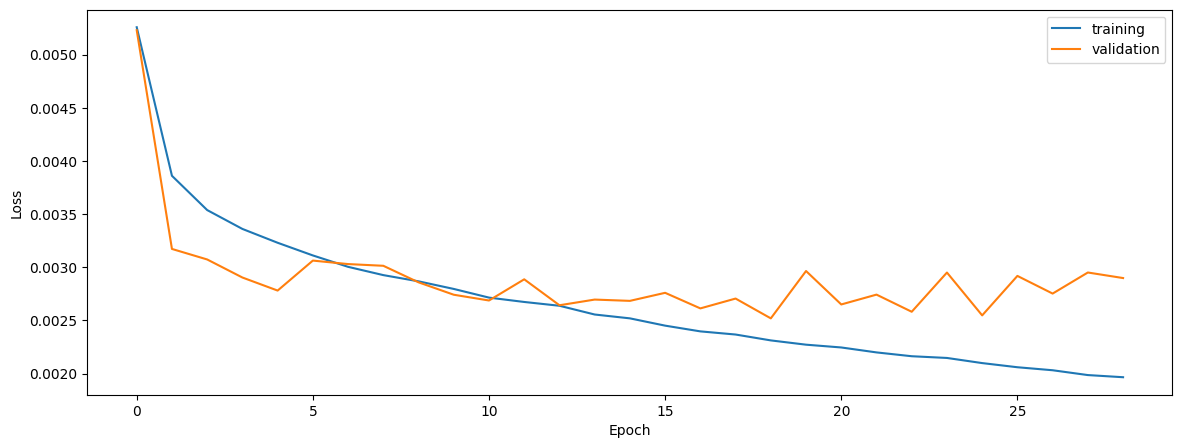

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8710784147734334
0.8436942395204958
0.8330091102205084


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8718664666413362
0.8528030090396252
0.8416204003334776


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8711534060102043
0.8509869132730804
0.8377020583832225


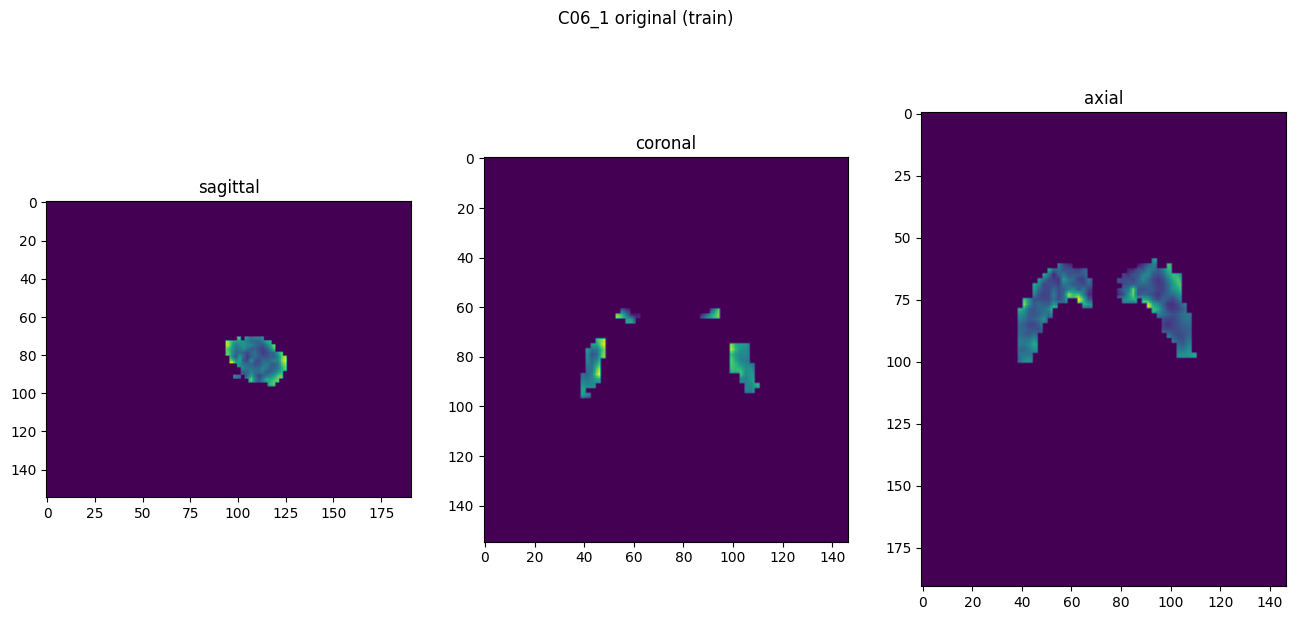

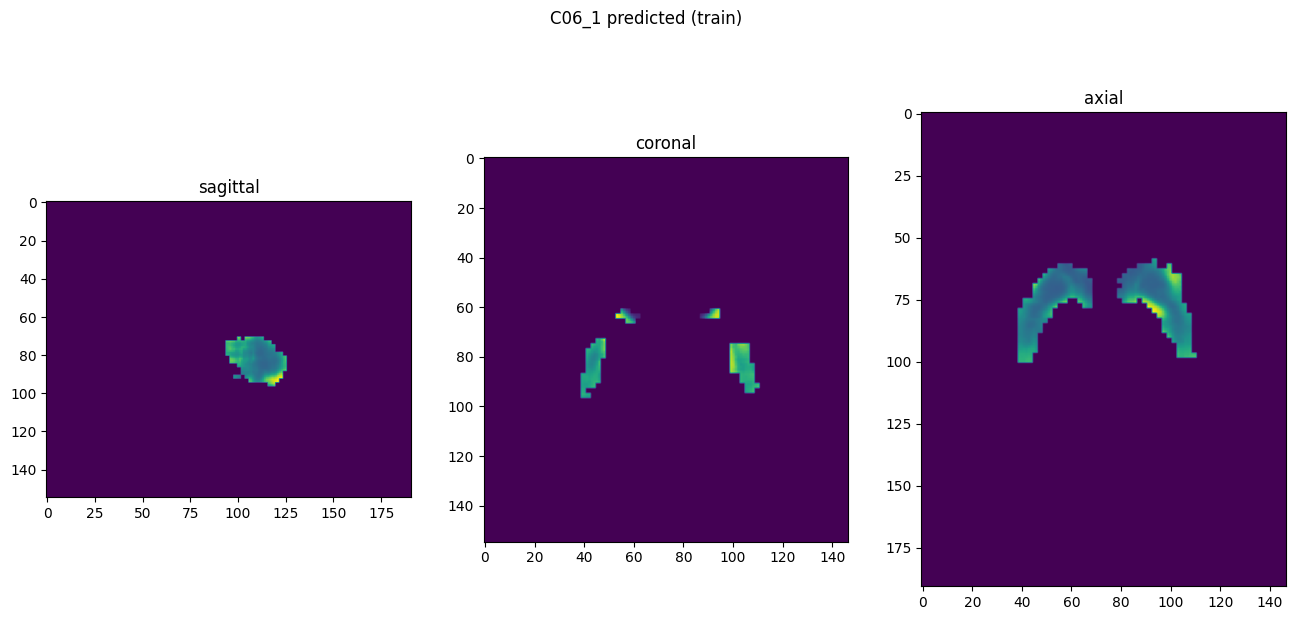

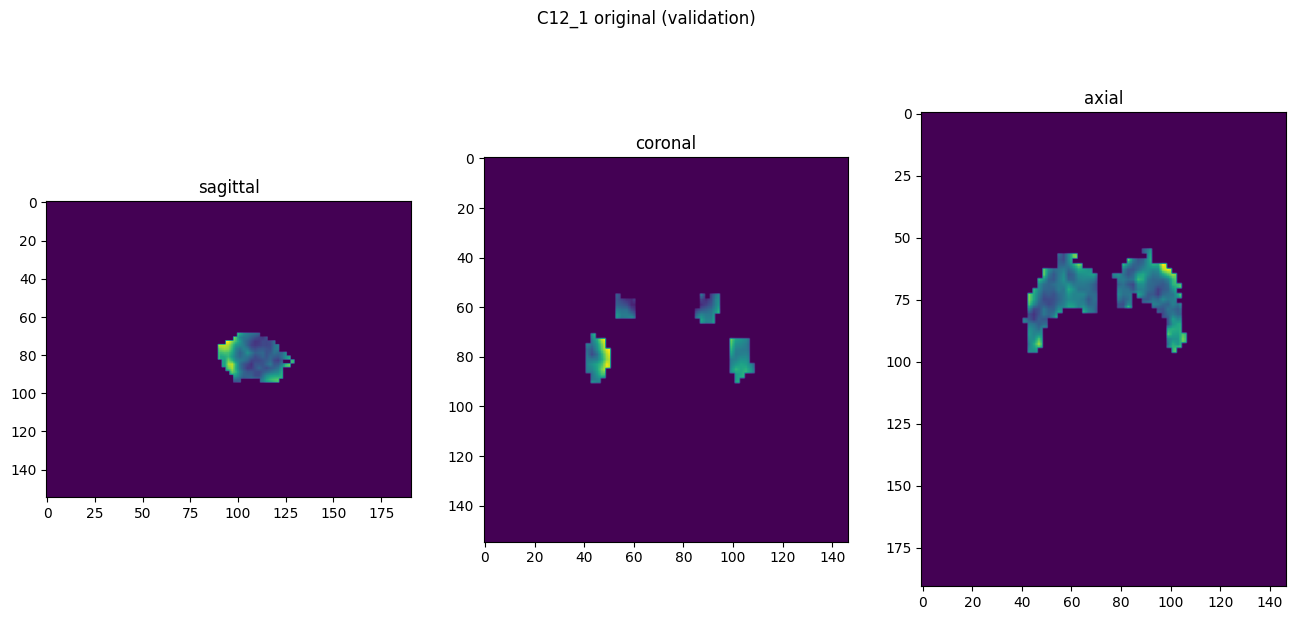

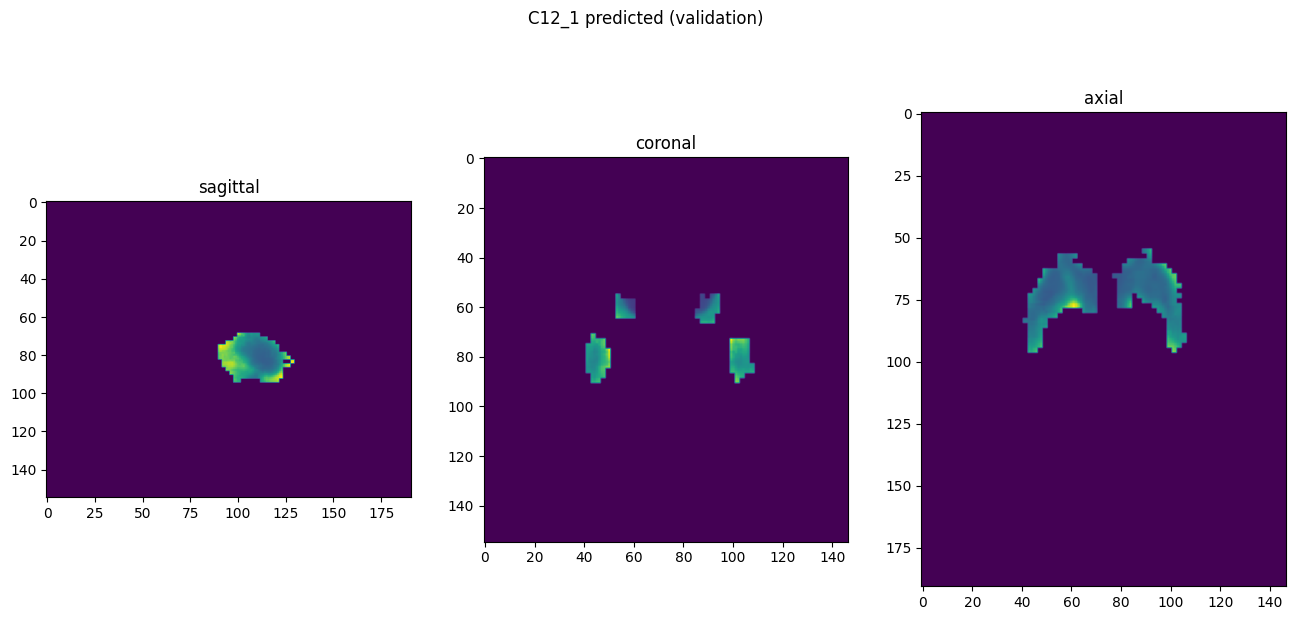

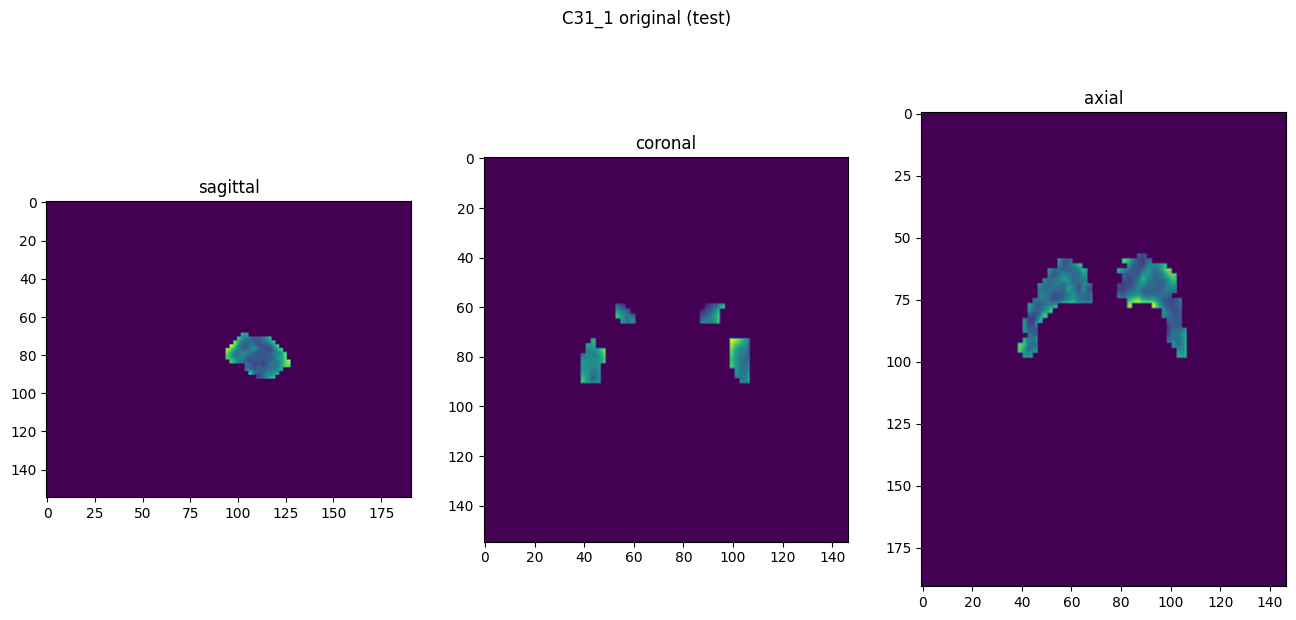

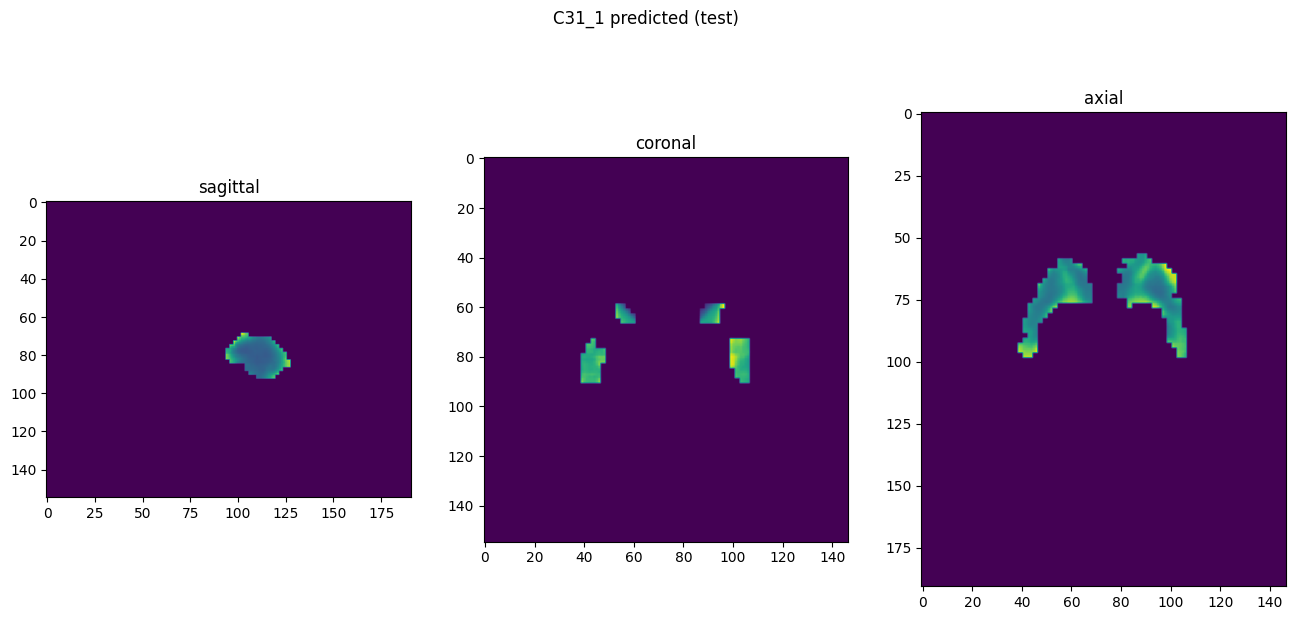

In [10]:
showResults(model, gen, threshold=None, background=False)